# Neural processes

We'll demonstrate training a neural process and an attentive neural process model using a batch of draws from a Gaussian process. First load some libraries.

In [1]:
%matplotlib inline
import fybdthemes
import matplotlib.pyplot as plt
from jax import numpy as jnp
from jax import random as jr
from matplotlib import rc

fybdthemes.set_theme()
rc("font", **{"family": "sans-serif", "sans-serif": ["Arial Narrow"]})

Next we sample some data from a Gaussian process:

In [2]:
from ramsey.data import sample_from_gaussian_process

sample_key, rng_key = jr.split(jr.key(0))
data = sample_from_gaussian_process(sample_key, batch_size=10, num_observations=200)
(x_target, y_target), f_target = (data.x, data.y), data.f

Visualize the batch of draws:

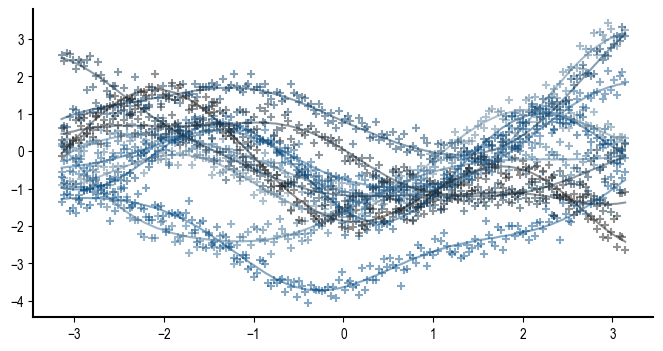

In [3]:
cols = fybdthemes.discrete_sequential_colors(10)

_, ax = plt.subplots(figsize=(8, 4))
for i in range(x_target.shape[0]):
    x = jnp.squeeze(x_target[i, :, :])
    y = jnp.squeeze(y_target[i, :, :])
    f = jnp.squeeze(f_target[i, :, :])
    idxs = jnp.argsort(x)
    ax.plot(x[idxs], f[idxs], color=cols[i], alpha=0.5)
    ax.scatter(x[idxs], y[idxs], marker="+", color=cols[i], alpha=0.5)
plt.show()

## Neural process

Having sampled a data set, we can define the model. A neural process model takes a `decoder` argument, a `latent_encoder` argument and an optional `deterministic_encoder` argument.

- The `decoder` is a neural network, typically an MLP, that maps the latent representation to the data space, or, more specifically, is used to parameterize an exponential family distribution. The decoder needs to respect the dimensionality of the response to be modelled. For instance, if the response is a univariate Gaussian the last layer needs to have two neurons: one do parameterize the mean and one to parameterize the variance of the Gaussian.

- The `latent_encoder` is a tuple of two neural networks, typically also two MLPs. The first of which maps the data to a latent representation. This representation gets averaged and then passed through the second MLP to parameterize a latent Gaussian.

- The `deterministic_encoder` is typically also an MLP that maps the data two a deterministic univariate representation.

Below we create a simple NP model with a decoder and a latent encoder. All networks are MLPs. The decoder has two neurons in its final layer (for mean and variance of the Gaussian that models the data), the encoder's final layer is 2*128 nodes to parameterize a latent 128 dimensional Gaussian.

In [4]:
from flax import nnx
from ramsey import NP
from ramsey.nn import MLP

def get_neural_process(in_features, out_features):
  dim = 64
  np = NP(
    latent_encoder=(
      MLP(in_features + out_features, [dim, dim], rngs=nnx.Rngs(0)),
      MLP(dim, [dim, dim * 2], rngs=nnx.Rngs(1))
    ),
    decoder=MLP(in_features + dim, [dim, dim, out_features * 2], rngs=nnx.Rngs(2)),
    rngs=nnx.Rngs(3)
  )
  return np

neural_process = get_neural_process(1, 1)

We use 10 context points and 20 target points per iteration of training:

In [5]:
from ramsey import train_neural_process

train_key, rng_key = jr.split(jr.key(0))
n_context, n_target = 10, 20
neural_process = train_neural_process(
    train_key,
    neural_process,
    x=x_target,
    y=y_target,
    n_context=n_context,
    n_target=n_target,
    n_iter=10_000,
    batch_size=2,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 263.69it/s]


That's it! Finally, we define a set of data points for a batch and make some predictions: 

In [6]:
sample_key, rng_key = jr.split(rng_key)

sample_idxs = jr.choice(
    sample_key, x_target.shape[1], shape=(n_target + n_context,), replace=False
)

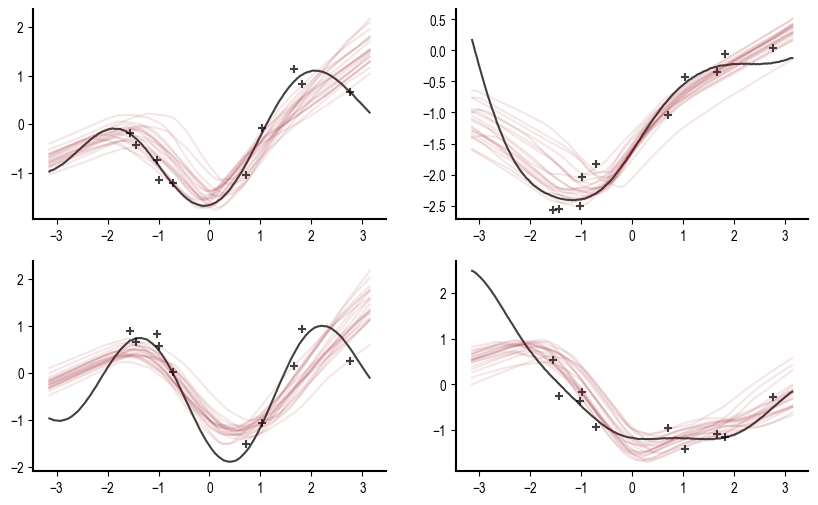

In [7]:
idxs = [0, 2, 5, 7]
_, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for _, (idx, ax) in enumerate(zip(idxs, axes.flatten())):
    x = jnp.squeeze(x_target[idx, :, :])
    f = jnp.squeeze(f_target[idx, :, :])
    y = jnp.squeeze(y_target[idx, :, :])

    srt_idxs = jnp.argsort(x)
    ax.plot(x[srt_idxs], f[srt_idxs], color="black", alpha=0.75)
    ax.scatter(
        x[sample_idxs[:n_context]],
        y[sample_idxs[:n_context]],
        color="black",
        marker="+",
        alpha=0.75,
    )

    for _ in range(20):
        sample_rng_key, rng_key = jr.split(rng_key, 2)
        y_star = neural_process(            
            x_context=x[jnp.newaxis, sample_idxs, jnp.newaxis],
            y_context=y[jnp.newaxis, sample_idxs, jnp.newaxis],
            x_target=x_target[[idx], :, :],
        ).mean
        x_star = jnp.squeeze(x_target[[idx], :, :])
        y_star = jnp.squeeze(y_star)
        ax.plot(x_star[srt_idxs], y_star[srt_idxs], color="#960C1A", alpha=0.1)
plt.show()

## Attentive neural process

An attentive neural process model takes a `decoder` argument, a `latent_encoder` argument and a `deterministic_encoder` argument with an attention module. In comparison to before the
`deterministic_encoder` is also a tuple in this case. In addition to the network that generates the representation, one is also requires to provide a mechanism for cross-attention.

Below we create an ANP model with a decoder a latent encoder and a deterministic encoder with `MultiHeadAttention`. The encoder itself is again an MLP, the `MultiHeadAttention` module takes also an MLP that embeds the keys and query into a higher dimensional space before attending to the query.

In [8]:
from ramsey import ANP
from ramsey.nn import MultiHeadAttention


def get_attentive_neural_process(in_features, out_features):
    dim = 64
    np = ANP(        
        latent_encoder=(
            MLP(in_features + out_features, [dim, dim, dim], rngs=nnx.Rngs(0)),
            MLP(dim, [dim, dim * 2], rngs=nnx.Rngs(1))
        ),
        deterministic_encoder=(
            MLP(in_features + out_features, [dim] * 3, rngs=nnx.Rngs(2)),
            MultiHeadAttention(
              dim, 
              num_heads=4,
              embedding=MLP(1, [dim, dim], rngs=nnx.Rngs(3)),
              rngs=nnx.Rngs(4)
            ),              
        ),
        decoder=MLP(in_features + 2 * dim, [dim, dim, dim, out_features * 2], rngs=nnx.Rngs(5)),
        rngs=nnx.Rngs(6)
    )
    return np


attentive_neural_process = get_attentive_neural_process(1, 1)

After the setup, the initialization of parameters and training is identical.

In [9]:
train_key, rng_key = jr.split(jr.PRNGKey(0))

attentive_neural_process = train_neural_process(
    train_key,
    attentive_neural_process,
    x=x_target,
    y=y_target,
    n_context=n_context,
    n_target=n_target,
    n_iter=10_000,
    batch_size=2,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 171.70it/s]


We again visualize some predictions.

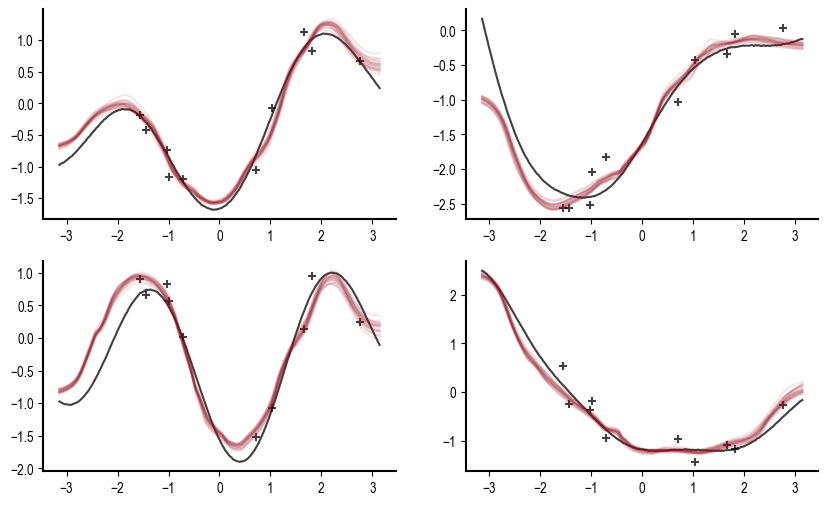

In [10]:
idxs = [0, 2, 5, 7]
_, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
for _, (idx, ax) in enumerate(zip(idxs, axes.flatten())):
    x = jnp.squeeze(x_target[idx, :, :])
    f = jnp.squeeze(f_target[idx, :, :])
    y = jnp.squeeze(y_target[idx, :, :])

    srt_idxs = jnp.argsort(x)
    ax.plot(x[srt_idxs], f[srt_idxs], color="black", alpha=0.75)
    ax.scatter(
        x[sample_idxs[:n_context]],
        y[sample_idxs[:n_context]],
        color="black",
        marker="+",
        alpha=0.75,
    )

    for _ in range(20):
        sample_rng_key, rng_key = jr.split(rng_key, 2)
        y_star = attentive_neural_process(            
            x_context=x[jnp.newaxis, sample_idxs, jnp.newaxis],
            y_context=y[jnp.newaxis, sample_idxs, jnp.newaxis],
            x_target=x_target[[idx], :, :],
        ).mean
        x_star = jnp.squeeze(x_target[[idx], :, :])
        y_star = jnp.squeeze(y_star)
        ax.plot(x_star[srt_idxs], y_star[srt_idxs], color="#960C1A", alpha=0.1)
plt.show()

We can see that the predictions have significantly less variance as before.

## Session info

In [11]:
import session_info

session_info.show(html=False)

-----
flax                0.10.2
fybdthemes          0.1.2
jax                 0.5.0
jaxlib              0.5.0
matplotlib          3.10.0
ramsey              0.3.0
seaborn             0.13.2
session_info        1.0.0
-----
IPython             8.32.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.3.5
notebook            7.3.2
-----
Python 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]
macOS-13.0.1-arm64-arm-64bit
-----
Session information updated at 2025-02-07 23:42


## References

- Garnelo, Marta, et al. "Conditional neural processes." ICML, 2018.
- Garnelo, Marta, et al. "Neural processes." ICML Workshop on Theoretical Foundations and Applications of Deep Generative Model, 2018.
- Kim, Hyunjik, et al. "Attentive neural processes." ICLR, 2019.